In [1]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from pathlib import Path
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score


from utilities.data_augmenting import process_date_group
from utilities.nn_utils import choose_device
from utilities.lstm_utils import TimeSeriesPredictionDataset, MultiInputTimeSeriesModel, TimeSeriesTrainer, predict

from IPython.display import display, Markdown
from tqdm.notebook import tqdm

# Load data

In [2]:
data_path = Path("/Users/adamsulik/Workspace/qrt_datachallenge/data")

output_storage_path = data_path.parent / 'outputs' / 'recurrent_network'
output_storage_path.mkdir(exist_ok=True, parents=True)

In [3]:
x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')

x_test = pd.read_csv(data_path / 'x_test_c7ETL4q.csv', index_col='ID')

In [4]:
# choose trainable columns
from itertools import product
pred_x_train = x_train[['DATE', 'STOCK'] + [f'{prefix}_{num}' for prefix, num in product(['RET', 'VOLUME'], range(2, 20+1))]].copy()
pred_x_train.rename(columns = {
    f'RET_{i}': f'RET_{i-1}' for i in range(2, 20+1)
}, inplace=True)
pred_x_train.rename(columns = {
    f'VOLUME_{i}': f'VOLUME_{i-1}' for i in range(2, 20+1)
}, inplace=True)

pred_y_train = x_train['RET_1']

In [5]:
# process prediction train dataset
t_34 = 5
halflife = np.log(2) / np.log(4/3) * t_34


train_processed_savepath = output_storage_path / 'preprocessed_x_train.h5'

groups_train = pred_x_train.groupby('DATE')
groups_processed = []

for date, group_df in tqdm(groups_train):
    print('Date: ', date)
    group_df = group_df.copy()
    group_df = process_date_group(group_df, halflife=halflife, distance_method='dist')
    groups_processed.append(group_df)
pd.concat(groups_processed).to_hdf(train_processed_savepath, key='preprocessed_train')
print(f'Saved to {train_processed_savepath}')

  0%|          | 0/156 [00:00<?, ?it/s]

Date:  0
First eigvec explains 29.93%
Second eigvec explains 7.04%
Date:  1
First eigvec explains 36.08%
Second eigvec explains 6.59%
Date:  4
First eigvec explains 28.39%
Second eigvec explains 7.38%
Date:  5
First eigvec explains 44.80%
Second eigvec explains 5.06%
Date:  6
First eigvec explains 31.64%
Second eigvec explains 6.11%
Date:  7
First eigvec explains 21.07%
Second eigvec explains 7.66%
Date:  9
First eigvec explains 36.24%
Second eigvec explains 9.58%
Date:  10
First eigvec explains 22.69%
Second eigvec explains 9.56%
Date:  11
First eigvec explains 25.57%
Second eigvec explains 8.97%
Date:  14
First eigvec explains 25.94%
Second eigvec explains 7.37%
Date:  18
First eigvec explains 38.80%
Second eigvec explains 6.66%
Date:  19


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 24.39%
Second eigvec explains 6.21%
Date:  20
First eigvec explains 27.79%
Second eigvec explains 10.08%
Date:  21
First eigvec explains 14.63%
Second eigvec explains 8.49%
Date:  22
First eigvec explains 37.94%
Second eigvec explains 6.05%
Date:  25
First eigvec explains 23.46%
Second eigvec explains 7.75%
Date:  28
First eigvec explains 19.70%
Second eigvec explains 11.91%
Date:  32
First eigvec explains 47.50%
Second eigvec explains 4.71%
Date:  33
First eigvec explains 29.40%
Second eigvec explains 6.50%
Date:  34
First eigvec explains 16.49%
Second eigvec explains 8.80%
Date:  35
First eigvec explains 21.17%
Second eigvec explains 7.42%
Date:  36
First eigvec explains 26.20%
Second eigvec explains 7.88%
Date:  38
First eigvec explains 27.98%
Second eigvec explains 7.93%
Date:  39
First eigvec explains 35.99%
Second eigvec explains 7.18%
Date:  40
First eigvec explains 17.60%
Second eigvec explains 7.63%
Date:  41
First eigvec explains 49.22%
Second eigvec exp

/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 38.47%
Second eigvec explains 6.94%
Date:  65
First eigvec explains 22.54%
Second eigvec explains 12.21%
Date:  67
First eigvec explains 60.59%
Second eigvec explains 4.35%
Date:  68
First eigvec explains 60.28%
Second eigvec explains 10.61%
Date:  69
First eigvec explains 31.84%
Second eigvec explains 7.48%
Date:  70
First eigvec explains 20.32%
Second eigvec explains 8.76%
Date:  71
First eigvec explains 37.84%
Second eigvec explains 8.27%
Date:  74
First eigvec explains 38.40%
Second eigvec explains 8.71%
Date:  75
First eigvec explains 29.48%
Second eigvec explains 8.86%
Date:  76
First eigvec explains 22.17%
Second eigvec explains 7.29%
Date:  77
First eigvec explains 27.59%
Second eigvec explains 7.26%
Date:  80
First eigvec explains 45.78%
Second eigvec explains 6.69%
Date:  81
First eigvec explains 32.46%
Second eigvec explains 6.25%
Date:  82
First eigvec explains 26.04%
Second eigvec explains 10.54%
Date:  84
First eigvec explains 17.46%
Second eigvec ex

/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 22.51%
Second eigvec explains 6.86%
Date:  122
First eigvec explains 29.01%
Second eigvec explains 6.37%
Date:  123


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 24.88%
Second eigvec explains 7.02%
Date:  124


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 32.32%
Second eigvec explains 8.58%
Date:  125
First eigvec explains 54.83%
Second eigvec explains 3.52%
Date:  127
First eigvec explains 16.70%
Second eigvec explains 9.32%
Date:  128


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 35.20%
Second eigvec explains 5.82%
Date:  129
First eigvec explains 32.28%
Second eigvec explains 6.71%
Date:  130
First eigvec explains 30.31%
Second eigvec explains 7.25%
Date:  134
First eigvec explains 28.77%
Second eigvec explains 9.11%
Date:  135
First eigvec explains 41.07%
Second eigvec explains 8.42%
Date:  136
First eigvec explains 33.76%
Second eigvec explains 7.38%
Date:  137
First eigvec explains 33.92%
Second eigvec explains 5.61%
Date:  138
First eigvec explains 25.68%
Second eigvec explains 8.65%
Date:  141
First eigvec explains 25.16%
Second eigvec explains 6.21%
Date:  142
First eigvec explains 22.83%
Second eigvec explains 8.11%
Date:  143
First eigvec explains 20.66%
Second eigvec explains 7.58%
Date:  144
First eigvec explains 16.87%
Second eigvec explains 7.33%
Date:  146
First eigvec explains 30.31%
Second eigvec explains 7.38%
Date:  147
First eigvec explains 15.98%
Second eigvec explains 7.74%
Date:  148
First eigvec explains 28.67%
Secon

/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 16.55%
Second eigvec explains 9.48%
Date:  166
First eigvec explains 21.38%
Second eigvec explains 8.74%
Date:  168
First eigvec explains 20.49%
Second eigvec explains 12.35%
Date:  169


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 31.99%
Second eigvec explains 9.01%
Date:  171
First eigvec explains 38.83%
Second eigvec explains 5.96%
Date:  173
First eigvec explains 37.79%
Second eigvec explains 6.08%
Date:  174
First eigvec explains 37.50%
Second eigvec explains 6.83%
Date:  177
First eigvec explains 33.13%
Second eigvec explains 6.93%
Date:  179
First eigvec explains 28.49%
Second eigvec explains 9.36%
Date:  180
First eigvec explains 27.88%
Second eigvec explains 7.31%
Date:  181
First eigvec explains 32.31%
Second eigvec explains 9.79%
Date:  182
First eigvec explains 26.99%
Second eigvec explains 8.03%
Date:  183
First eigvec explains 35.80%
Second eigvec explains 6.00%
Date:  184
First eigvec explains 29.98%
Second eigvec explains 7.19%
Date:  186
First eigvec explains 16.53%
Second eigvec explains 8.33%
Date:  188
First eigvec explains 36.03%
Second eigvec explains 9.23%
Date:  189
First eigvec explains 24.21%
Second eigvec explains 10.54%
Date:  193
First eigvec explains 16.36%
Seco

/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 18.88%
Second eigvec explains 7.52%
Date:  195
First eigvec explains 29.50%
Second eigvec explains 5.67%
Date:  196
First eigvec explains 22.99%
Second eigvec explains 8.26%
Date:  197
First eigvec explains 27.93%
Second eigvec explains 7.43%
Date:  198
First eigvec explains 21.65%
Second eigvec explains 7.15%
Date:  202
First eigvec explains 30.87%
Second eigvec explains 16.89%
Date:  203
First eigvec explains 23.78%
Second eigvec explains 8.77%
Date:  204
First eigvec explains 25.82%
Second eigvec explains 8.27%
Date:  206
First eigvec explains 47.67%
Second eigvec explains 4.90%
Date:  208
First eigvec explains 20.94%
Second eigvec explains 7.68%
Date:  209
First eigvec explains 50.97%
Second eigvec explains 4.95%
Date:  210
First eigvec explains 31.00%
Second eigvec explains 7.27%
Date:  211
First eigvec explains 19.79%
Second eigvec explains 9.37%
Date:  213
First eigvec explains 23.73%
Second eigvec explains 7.61%
Date:  214
First eigvec explains 31.06%
Seco

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_39504/71725696.py:16: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block3_values] [items->Index(['Group_ret_1', 'Group_ret_2', 'Group_ret_3', 'Group_ret_4',
       'Group_ret_5'],
      dtype='object')]

  pd.concat(groups_processed).to_hdf(train_processed_savepath, key='preprocessed_train')


In [ ]:
# preprocess big val set: train but not shifted
bigval_processed_savepath = output_storage_path / 'preprocessed_x_bigval.h5'
t_34 = 5
halflife = np.log(2) / np.log(4/3) * t_34

pred_x_bigval = x_train[['DATE', 'STOCK'] + [f'{prefix}_{num}' for prefix, num in product(['RET', 'VOLUME'], range(1, 20))]].copy()

groups_bigval = pred_x_bigval.groupby('DATE')
groups_processed = []

for date, group_df in tqdm(groups_bigval):
    print('Date: ', date)
    group_df = group_df.copy()
    group_df = process_date_group(group_df, halflife=halflife, distance_method='dist')
    groups_processed.append(group_df)
    
pd.concat(groups_processed).to_hdf(bigval_processed_savepath, key='preprocessed_bigval')
print(f'Saved to {bigval_processed_savepath}')

In [234]:
# preprocess evaluation dataset
eval_processed_savepath = output_storage_path / 'preprocessed_x_eval.h5'
t_34 = 5
halflife = np.log(2) / np.log(4/3) * t_34

pred_x_eval = x_test[['DATE', 'STOCK'] + [f'{prefix}_{num}' for prefix, num in product(['RET', 'VOLUME'], range(1, 20))]].copy()
groups_eval = pred_x_eval.groupby('DATE')
groups_processed = []

pbar = tqdm(groups_eval)
for date, group_df in pbar:
    pbar.set_description(f'Evaluating date: {date}')
    group_df = group_df.copy()
    group_df = process_date_group(group_df, halflife=halflife, distance_method='dist')
    groups_processed.append(group_df)
pd.concat(groups_processed).to_hdf(eval_processed_savepath, key='preprocessed_eval')
print(f'Saved to: {eval_processed_savepath}')

  0%|          | 0/68 [00:00<?, ?it/s]

First eigvec explains 32.98%
Second eigvec explains 6.68%
First eigvec explains 35.37%
Second eigvec explains 8.40%
First eigvec explains 27.23%
Second eigvec explains 9.37%
First eigvec explains 14.15%
Second eigvec explains 9.16%
First eigvec explains 41.90%
Second eigvec explains 6.14%
First eigvec explains 37.81%
Second eigvec explains 9.71%
First eigvec explains 13.85%
Second eigvec explains 9.72%
First eigvec explains 32.96%
Second eigvec explains 6.89%
First eigvec explains 27.21%
Second eigvec explains 4.34%
First eigvec explains 17.25%
Second eigvec explains 8.22%
First eigvec explains 37.61%
Second eigvec explains 9.18%
First eigvec explains 51.33%
Second eigvec explains 5.89%
First eigvec explains 40.45%
Second eigvec explains 7.40%
First eigvec explains 44.00%
Second eigvec explains 5.99%
First eigvec explains 60.89%
Second eigvec explains 3.55%
First eigvec explains 34.02%
Second eigvec explains 6.69%


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:48: RuntimeWarning: invalid value encountered in scalar divide
  corr = cov / (stds[i] * stds[j])


First eigvec explains 25.10%
Second eigvec explains 7.52%


/Users/adamsulik/Workspace/qrt_datachallenge/notebooks/utilities/data_augmenting.py:137: RuntimeWarning: invalid value encountered in divide
  group_df.loc[:, ret_cols] = group_df[ret_cols].values / group_df['ret_std'].fillna(1).values[:, np.newaxis]


First eigvec explains 32.88%
Second eigvec explains 6.28%
First eigvec explains 51.57%
Second eigvec explains 5.14%
First eigvec explains 41.79%
Second eigvec explains 6.22%
First eigvec explains 70.59%
Second eigvec explains 4.47%
First eigvec explains 41.49%
Second eigvec explains 6.84%
First eigvec explains 24.29%
Second eigvec explains 8.43%
First eigvec explains 15.47%
Second eigvec explains 9.67%
First eigvec explains 42.38%
Second eigvec explains 2.73%
First eigvec explains 40.75%
Second eigvec explains 6.36%
First eigvec explains 29.53%
Second eigvec explains 8.50%
First eigvec explains 36.09%
Second eigvec explains 11.53%
First eigvec explains 29.03%
Second eigvec explains 9.84%
First eigvec explains 39.74%
Second eigvec explains 6.36%
First eigvec explains 18.21%
Second eigvec explains 11.69%
First eigvec explains 38.29%
Second eigvec explains 7.73%
First eigvec explains 40.37%
Second eigvec explains 7.82%
First eigvec explains 33.78%
Second eigvec explains 7.07%
First eigvec

/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_43291/257431144.py:16: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->floating,key->block3_values] [items->Index(['Group_ret_1', 'Group_ret_2', 'Group_ret_3', 'Group_ret_4',
       'Group_ret_5'],
      dtype='object')]

  pd.concat(groups_processed).to_hdf(eval_processed_savepath, key='preprocessed_eval')


# Train model

In [5]:
def prepare_lstm_dataset(xdf, ydf, dateback_range=5, maxvol=2):
    time_series_columns = [f'RET_{i}' for i in range(dateback_range, 0, -1)]
    time_series = xdf[time_series_columns].fillna(0)
    time_series = torch.tensor(time_series.values[:, :, np.newaxis], dtype=torch.float32)

    # set max value of Volume to maxvol
    vol_columns = [c for c in xdf.columns if c.startswith('VOLUME_')]
    xdf.loc[:, vol_columns] = xdf[vol_columns].clip(upper=maxvol)
    
    attributes_columns = [f'VOLUME_{i}' for i in range(dateback_range, 0, -1)] + \
                         [f'Group_ret_{i}' for i in range(1, 5+1)] + \
                         [f'global_avg_{i}' for i in range(1, 2+1)]
    
    
    attributes = torch.tensor(xdf[attributes_columns].astype(float).fillna(0).values, dtype=torch.float32)
    targets = torch.tensor(ydf.values[:, np.newaxis], dtype=torch.float32)
    time_series_features = time_series.shape[2]
    num_attributes = attributes.shape[1]
    return TimeSeriesPredictionDataset(time_series,
                                       attributes,
                                       targets), time_series_features, num_attributes

In [191]:
dateback_range = 10

def _preds2df(preds, targets):
    predictions = pd.Series(np.array(preds).ravel(), name='predictions')
    val_targets = pd.Series(np.array(targets).ravel(), name='targets')
    preds_df = pd.DataFrame([predictions, val_targets]).T
    return preds_df

def _simplestats(predsignsdf):
    ret_dict = {}
    predsignsdf = (predsignsdf > 0).astype(int)
    ret_dict['acc'] = accuracy_score(predsignsdf['predictions'], predsignsdf['targets'])
    ret_dict['pos_frac'] = predsignsdf['targets'].value_counts()[1] / len(predsignsdf)
    return ret_dict

def train_model(X_df, Y_df, train_index, test_index, learning_rate,
                max_epochs, hidden_sizes=[32, 16], lstm_hidden_size=16, dropout_rate=0.3, sign_penalty=1.0,
                device=choose_device(), print_every=5):
    # setup train/val sets
    # X_df_train = X_df.loc[X_df['DATE'].isin(train_split)]
    # Y_df_train = Y_df.loc[X_df_train.index]
    # X_df_val = X_df.loc[X_df['DATE'].isin(test_split)]
    # Y_df_val = Y_df.loc[X_df_val.index]

    X_df_train = X_df.loc[train_index]
    Y_df_train = Y_df.loc[X_df_train.index]
    X_df_val = X_df.loc[test_index]
    Y_df_val = Y_df.loc[X_df_val.index]

    # prepare datasets and dataloaders
    train_dataset, time_series_features, num_attributes = prepare_lstm_dataset(X_df_train, Y_df_train, dateback_range)
    val_dataset, _, _ = prepare_lstm_dataset(X_df_val, Y_df_val, dateback_range)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)

    # define model
    model = MultiInputTimeSeriesModel(
        time_series_features=time_series_features,
        num_attributes=num_attributes,
        hidden_sizes=hidden_sizes,
        lstm_hidden_size=lstm_hidden_size,
        dropout_rate=dropout_rate,
    ).to(device)

    # setup trainer pipeline
    trainer = TimeSeriesTrainer(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        patience=max_epochs,
        sign_penalty=sign_penalty,
    )

    # train the model
    training_history = trainer.train(max_epochs=max_epochs, print_every=print_every)
    trainer.plot_learning_curves(training_history)

    predictions = predict(
        model,
        val_dataset.time_series,
        val_dataset.attributes,
        device = choose_device(),
    )

    predictions_train = predict(
        model,
        train_dataset.time_series,
        train_dataset.attributes,
        device = 'cpu'
    )

    train_preds_df = _preds2df(predictions_train, train_dataset.targets)
    train_preds_sign = np.sign(train_preds_df)
    train_stats = _simplestats(train_preds_sign)
    
    val_preds_df = _preds2df(predictions, val_dataset.targets)
    val_preds_sign = np.sign(val_preds_df)
    val_stats = _simplestats(val_preds_sign)

    random_preds = _preds2df(np.random.choice([-1.0, 1.0], len(val_preds_sign),
                                              p=[1-val_stats['pos_frac'], val_stats['pos_frac']]), val_dataset.targets)
    random_sign = np.sign(random_preds)
    random_stats = _simplestats(random_sign)

    unique_train_dates_num = np.unique(X_df_train['DATE'], return_counts=False).size
    unique_val_dates_num = np.unique(X_df_val['DATE'], return_counts=False).size
    
    print(f"Train sign acc: {train_stats['acc']:.4f} | Val sign acc: {val_stats['acc']:.4f} | random acc: {random_stats['acc']:.4f}" )
    print(f"Train pos fraction: {train_stats['pos_frac']:.2f} | Val pos fraction: {val_stats['pos_frac']:.2f}" )
    print(f"Trainset size: {len(train_dataset)} | Val size: {len(val_dataset)}")
    print(f"Train unique dates: {unique_train_dates_num} | Val unique dates: {unique_val_dates_num}")

    return model, val_stats['acc']

In [219]:
train_processed_savepath = output_storage_path / 'preprocessed_x_train.h5'

X_df = pd.read_hdf(train_processed_savepath).reset_index(drop=True)
X_df['ret_std'] = X_df['ret_std'].fillna(1)
X_df.fillna(0, inplace=True)
Y_df = (pred_y_train.loc[X_df.index] / X_df['ret_std']).fillna(0).replace([np.inf, -np.inf], 0).clip(upper=2, lower=-5)


/var/folders/4j/_p_42xsd5395pr3dqwmj_03m0000gn/T/ipykernel_43291/607467994.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_df.fillna(0, inplace=True)


  0%|          | 0/5 [00:00<?, ?it/s]

/Users/adamsulik/Workspace/qrt_datachallenge/.dcvenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
Train Loss: 3.1837, Val Loss: 3.3443
MAE: 0.8153, RMSE: 1.0914, R²: -0.0051

Epoch 2/15
Train Loss: 3.1811, Val Loss: 3.3680
MAE: 0.8164, RMSE: 1.0924, R²: -0.0071

Epoch 3/15
Train Loss: 3.1872, Val Loss: 3.3979
MAE: 0.8181, RMSE: 1.0947, R²: -0.0113

Epoch 4/15
Train Loss: 3.1790, Val Loss: 3.4269
MAE: 0.8189, RMSE: 1.0959, R²: -0.0134

Epoch 5/15
Train Loss: 3.1785, Val Loss: 3.3883
MAE: 0.8184, RMSE: 1.0950, R²: -0.0118

Epoch 6/15
Train Loss: 3.1808, Val Loss: 3.3914
MAE: 0.8182, RMSE: 1.0951, R²: -0.0120

Epoch 7/15
Train Loss: 3.1787, Val Loss: 3.3640
MAE: 0.8186, RMSE: 1.0957, R²: -0.0131

Epoch 8/15
Train Loss: 3.1740, Val Loss: 3.4221
MAE: 0.8185, RMSE: 1.0957, R²: -0.0132

Epoch 9/15
Train Loss: 3.1777, Val Loss: 3.4234
MAE: 0.8200, RMSE: 1.0977, R²: -0.0168

Epoch 10/15
Train Loss: 3.1749, Val Loss: 3.3976
MAE: 0.8199, RMSE: 1.0975, R²: -0.0164

Epoch 11/15
Train Loss: 3.1667, Val Loss: 3.3993
MAE: 0.8188, RMSE: 1.0960, R²: -0.0136

Epoch 12/15
Train Loss: 3.1726

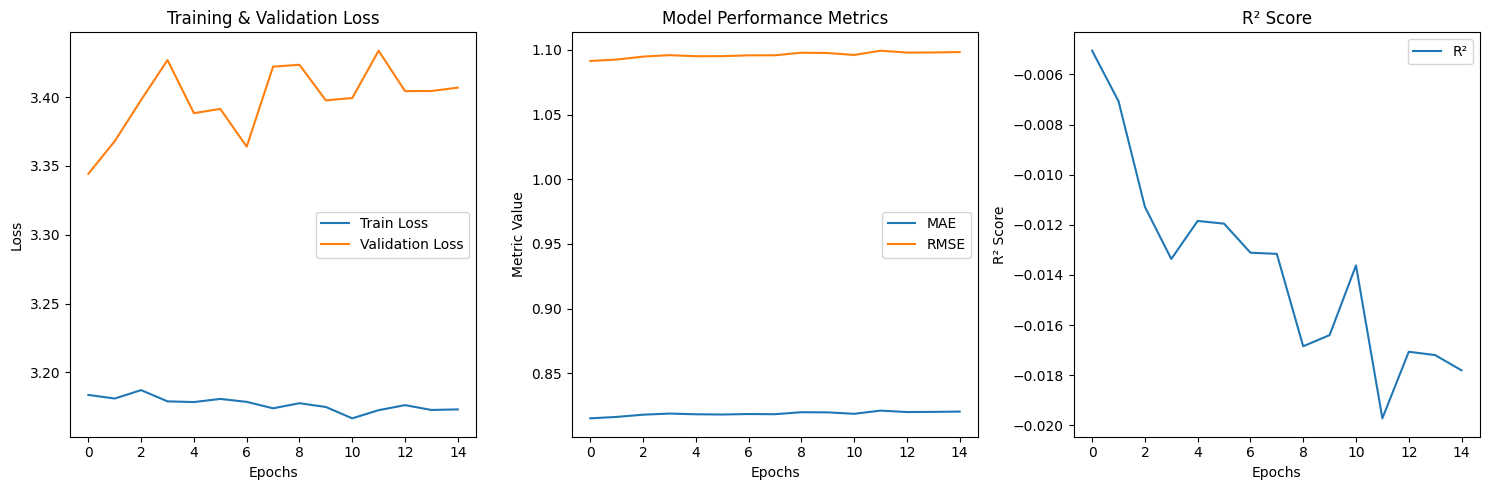

Train sign acc: 0.5708 | Val sign acc: 0.5264 | random acc: 0.4986
Train pos fraction: 0.50 | Val pos fraction: 0.50
Trainset size: 200000 | Val size: 80000
Train unique dates: 116 | Val unique dates: 39


/Users/adamsulik/Workspace/qrt_datachallenge/.dcvenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
Train Loss: 3.1936, Val Loss: 3.3458
MAE: 0.8161, RMSE: 1.0922, R²: -0.0067

Epoch 2/15
Train Loss: 3.1869, Val Loss: 3.3689
MAE: 0.8181, RMSE: 1.0951, R²: -0.0119

Epoch 3/15
Train Loss: 3.1864, Val Loss: 3.4105
MAE: 0.8180, RMSE: 1.0946, R²: -0.0111

Epoch 4/15
Train Loss: 3.1841, Val Loss: 3.4511
MAE: 0.8175, RMSE: 1.0941, R²: -0.0101

Epoch 5/15
Train Loss: 3.1947, Val Loss: 3.4167
MAE: 0.8207, RMSE: 1.0989, R²: -0.0189

Epoch 6/15
Train Loss: 3.1862, Val Loss: 3.4013
MAE: 0.8208, RMSE: 1.0993, R²: -0.0198

Epoch 7/15
Train Loss: 3.1832, Val Loss: 3.4570
MAE: 0.8204, RMSE: 1.0991, R²: -0.0193

Epoch 8/15
Train Loss: 3.1861, Val Loss: 3.4606
MAE: 0.8196, RMSE: 1.0971, R²: -0.0156

Epoch 9/15
Train Loss: 3.1914, Val Loss: 3.4584
MAE: 0.8242, RMSE: 1.1024, R²: -0.0255

Epoch 10/15
Train Loss: 3.1927, Val Loss: 3.4764
MAE: 0.8241, RMSE: 1.1026, R²: -0.0259

Epoch 11/15
Train Loss: 3.1872, Val Loss: 3.4478
MAE: 0.8220, RMSE: 1.1003, R²: -0.0216

Epoch 12/15
Train Loss: 3.1888

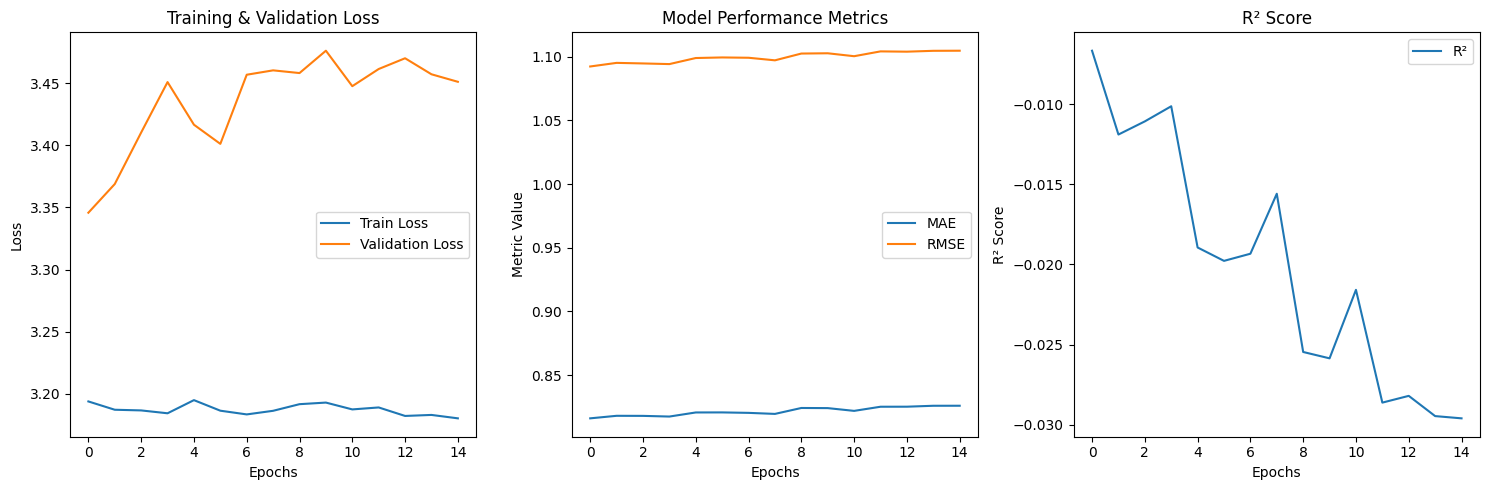

Train sign acc: 0.5730 | Val sign acc: 0.5140 | random acc: 0.5003
Train pos fraction: 0.50 | Val pos fraction: 0.50
Trainset size: 200000 | Val size: 80000
Train unique dates: 116 | Val unique dates: 39


/Users/adamsulik/Workspace/qrt_datachallenge/.dcvenv/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/15
Train Loss: 3.2666, Val Loss: 3.3851
MAE: 0.8176, RMSE: 1.0940, R²: -0.0100

Epoch 2/15
Train Loss: 3.2135, Val Loss: 3.4612
MAE: 0.8215, RMSE: 1.0996, R²: -0.0202

Epoch 3/15
Train Loss: 3.2162, Val Loss: 3.4185
MAE: 0.8201, RMSE: 1.0983, R²: -0.0180

Epoch 4/15
Train Loss: 3.2114, Val Loss: 3.4681
MAE: 0.8234, RMSE: 1.1035, R²: -0.0276

Epoch 5/15
Train Loss: 3.2104, Val Loss: 3.4661
MAE: 0.8234, RMSE: 1.1022, R²: -0.0252

Epoch 6/15
Train Loss: 3.2117, Val Loss: 3.4834
MAE: 0.8222, RMSE: 1.1007, R²: -0.0224

Epoch 7/15
Train Loss: 3.2106, Val Loss: 3.5077
MAE: 0.8222, RMSE: 1.1005, R²: -0.0220

Epoch 8/15
Train Loss: 3.2054, Val Loss: 3.4848
MAE: 0.8223, RMSE: 1.1012, R²: -0.0232

Epoch 9/15
Train Loss: 3.2093, Val Loss: 3.4977
MAE: 0.8226, RMSE: 1.1015, R²: -0.0238

Epoch 10/15
Train Loss: 3.2059, Val Loss: 3.4817
MAE: 0.8221, RMSE: 1.1004, R²: -0.0217

Epoch 11/15
Train Loss: 3.1946, Val Loss: 3.4921
MAE: 0.8232, RMSE: 1.1021, R²: -0.0250

Epoch 12/15
Train Loss: 3.2008

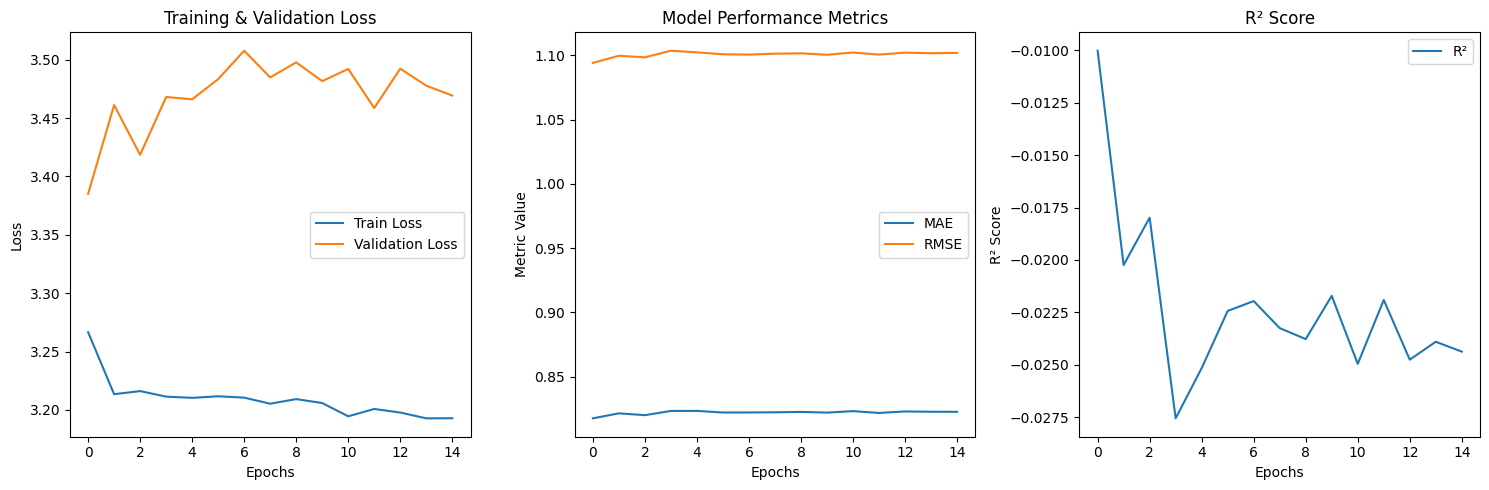

Train sign acc: 0.5689 | Val sign acc: 0.5141 | random acc: 0.4985
Train pos fraction: 0.50 | Val pos fraction: 0.50
Trainset size: 200000 | Val size: 80000
Train unique dates: 116 | Val unique dates: 39
joined_accuracy: 0.5179


In [222]:
# sample data for model training
train_samples = 200000
val_samples = 80000
max_epochs = 15
learning_rate = 1e-3
hidden_sizes = [32, 16]
lstm_hidden_size = 4
sign_penalty = 3

def sample_date_dataset(xdf, ydf, num_samples, dates):
    xdf = xdf.loc[xdf['DATE'].isin(dates)]
    ydf = ydf.loc[xdf.index]
    pos_returns_ix = ydf.loc[ydf > 0].index
    neg_returns_ix = ydf.loc[ydf < 0].index
    return np.concat([np.random.choice(pos_returns_ix, num_samples, replace=False),
                      np.random.choice(neg_returns_ix, num_samples, replace=False)])


np.random.seed(42)
unique_dates = X_df['DATE'].unique()

iteration_storage = {}

for storage_ind in tqdm(range(5)):
    np.random.shuffle(unique_dates)
    grouped_dates = np.array_split(unique_dates, 4)
    
    val_dates = grouped_dates[0]
    val_index = sample_date_dataset(X_df, Y_df, val_samples//2, val_dates)
    train_sets = [sample_date_dataset(X_df, Y_df, train_samples//2, np.concat(grouped_dates[1:])) for _ in range(len(grouped_dates)-1)]
    
    # train unique models
    models = []
    val_acc_arr = []
    for train_index in train_sets:
        model, val_acc = train_model(X_df, Y_df, train_index, val_index,
                                     learning_rate, max_epochs,
                                     hidden_sizes=hidden_sizes, lstm_hidden_size=lstm_hidden_size,
                                     dropout_rate=0.4, sign_penalty=sign_penalty,
                                     device=choose_device(), print_every=1)
        models.append(model)
        val_acc_arr.append(val_acc)
        
    X_df_val = X_df.loc[val_index]
    Y_df_val = Y_df.loc[X_df_val.index]
    val_dataset, _, _ = prepare_lstm_dataset(X_df_val, Y_df_val, dateback_range)
    # Build predictions out of all trained models
    model_preds_arr = []
    for model in models:
        predictions = predict(
            model,
            val_dataset.time_series,
            val_dataset.attributes,
            device = choose_device(),
        )
        val_preds_df = _preds2df(predictions, val_dataset.targets)
        val_preds_sign = np.sign(val_preds_df)
        model_preds_arr.append(val_preds_sign)
    
    def _most_frequent(row):
        counts = row.value_counts()
        max_count = counts.max()
        most_frequent_values = counts[counts == max_count].index
        return 1 if len(most_frequent_values) > 1 else most_frequent_values[0]
        
    joined_preds_df = pd.DataFrame()
    for i, model_preds in enumerate(model_preds_arr, 1):
        joined_preds_df[f'model_{i}'] = model_preds['predictions']
    target = model_preds['targets']
    
    most_frequent_pred = joined_preds_df.apply(_most_frequent, axis=1)
    targets_series = pd.Series(np.array(target).ravel(), name='targets')
    joined_accuracy = accuracy_score(most_frequent_pred, targets_series)

    iteration_storage[storage_ind] = {'models': models, 'val_acc_arr': val_acc_arr, 'joined_accuracy': joined_accuracy}
    print(f'joined_accuracy: {joined_accuracy:.4f}')

    # !!!
    break

In [223]:
joined_acc_arr = []
for _, s in iteration_storage.items():
    mean_acc, std_acc = np.mean(s['val_acc_arr']), np.std(s['val_acc_arr'])
    joined_acc = s['joined_accuracy']
    joined_acc_arr.append(joined_acc)
    print(f"avg acc: {mean_acc:.4f} ({mean_acc-std_acc:4f}; {mean_acc+std_acc:4f}); std acc: {std_acc:.4f}; joined acc: {joined_acc}")

avg acc: 0.5182 (0.512329; 0.523996); std acc: 0.0058; joined acc: 0.517875


In [224]:
mean_acc, std_acc = np.mean(joined_acc_arr), np.std(joined_acc_arr)
print(f"avg acc: {mean_acc:.4f} ({mean_acc-std_acc:4f}; {mean_acc+std_acc:4f}); std acc: {std_acc:.4f}")

avg acc: 0.5179 (0.517875; 0.517875); std acc: 0.0000


In [225]:
x_train = pd.read_csv(data_path / 'x_train_Lafd4AH.csv', index_col='ID')
y_train = pd.read_csv(data_path / 'y_train_JQU4vbI.csv', index_col='ID')

bigval_processed_savepath = output_storage_path / 'preprocessed_x_bigval.h5'
bigval_x_df = pd.read_hdf(bigval_processed_savepath).reset_index(drop=True)

bigval_dataset, _, _ = prepare_lstm_dataset(bigval_x_df, y_train['RET'], dateback_range)

In [226]:
def _most_frequent(row):
    counts = row.value_counts()
    max_count = counts.max()
    most_frequent_values = counts[counts == max_count].index
    return 1 if len(most_frequent_values) > 1 else most_frequent_values[0]

joined_preds_df = pd.DataFrame()
model_num = 0

for key, its in tqdm(iteration_storage.items()):
    its_models = its['models']
    for model in its_models:
        model_num += 1
        predictions = predict(
            model,
            bigval_dataset.time_series,
            bigval_dataset.attributes,
            device = choose_device(),
        )
        bigval_preds_df = _preds2df(predictions, bigval_dataset.targets)
        bigval_preds_sign = np.sign(bigval_preds_df)
        joined_preds_df[f'model_{model_num}'] = bigval_preds_sign['predictions']
    

  0%|          | 0/1 [00:00<?, ?it/s]

In [230]:
# big_val_most_frequent = joined_preds_df.iloc[:, 12:].apply(_most_frequent, axis=1)
chosen_preds = joined_preds_df[[f'model_{cn}' for cn in [1, 2, ]]]
big_val_most_frequent = (chosen_preds > 0).astype(int).mean(axis=1) > 0.5
big_val_most_frequent = (big_val_most_frequent > 0).astype(int)

(big_val_most_frequent == y_train['RET'].astype(int)).sum() / len(big_val_most_frequent)

np.float64(0.5001254195582843)

In [245]:
X_df_eval = pd.read_hdf(output_storage_path / 'preprocessed_x_eval.h5')
X_df_eval.index = x_test.index
eval_dataset, _, _ = prepare_lstm_dataset(X_df_eval, pd.Series(0, index=X_df_eval.index), dateback_range)

In [247]:
joined_eval_preds_df = pd.DataFrame()
model_num = 0

for key, its in tqdm(iteration_storage.items()):
    its_models = its['models']
    for model in its_models:
        model_num += 1
        predictions = predict(
            model,
            eval_dataset.time_series,
            eval_dataset.attributes,
            device = choose_device(),
        )
        eval_preds_df = _preds2df(predictions, eval_dataset.targets)
        eval_pred_sign = np.sign(eval_preds_df)
        joined_eval_preds_df[f'model_{model_num}'] = eval_pred_sign['predictions']

  0%|          | 0/1 [00:00<?, ?it/s]